<a href="https://colab.research.google.com/github/tonchan1216/bitbot/blob/master/notebook/predict_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
from google.colab import drive
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, ReLU
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## データの読み込み

In [175]:
drive.mount('/content/drive/')

base_path = '/content/drive/My Drive/Colab Notebooks/bitbot/training_data/'
train_data = pd.read_csv(base_path + 'btc_all.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 前処理

shift =>

threashold => 上昇率N％以上で、上昇。下降率N％以下で、下降。それ以外は停滞

In [176]:
def process(input_df, shift = 8, threshold = 0.02):
  x = pd.concat([input_df.shift(-1*i) for i in range(shift)], axis=1)
  x = x.dropna()
  x = x.set_axis([str(i-6) for i in range(shift)], axis=1)
  m = np.array(x.mean(axis='columns'))
  s = np.array(x.std(axis='columns'))
  x = x.sub(m, axis=0).div(s, axis=0)
  x['change_rate'] = (x['1'] - x['0']) / x['0']

  y = pd.DataFrame({'up': np.zeros(len(x)), 'down': np.zeros(len(x)), 'even': np.zeros(len(x))})
  y.loc[x['change_rate'] > threshold, 'up'] = 1 # 上昇トレンド
  y.loc[x['change_rate'] < -threshold, 'down'] = 1 # 下降トレンド
  y.loc[(x['change_rate'] < threshold) & (x['change_rate'] > -threshold), 'down'] = 1 # 停滞トレンド

  x = x.drop('change_rate',axis=1)
  x = x.drop('1',axis=1)
  return np.array(x), np.array(y)

input_tensor, label_tensor = process(train_data['BTC'])
train_x, test_x, train_y, test_y = train_test_split(input_tensor, label_tensor, test_size=0.2, random_state=100, shuffle = False)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1897, 7)
(1897, 3)
(475, 7)
(475, 3)


## Model構築

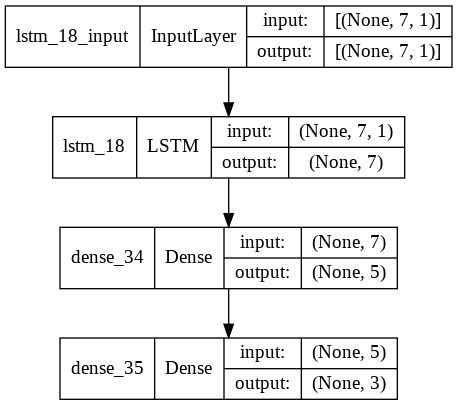

In [177]:
optimizer = Adam()

model = Sequential()
model.add(LSTM(7,
             dropout=0.2,
             recurrent_dropout=0.2,
             input_shape=(7,1)))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer=optimizer,
           loss='categorical_crossentropy',
           metrics=['acc'])

plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')

## 学習

scrkit-learnと同様fitで記述できる

In [178]:
earlystopping = EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_x, train_y,
 batch_size=10,
 epochs=50,
 callbacks=[earlystopping],
 verbose=1,
 validation_data=(test_x, test_y))

Epoch 1/50
190/190 [==============================] - 4s 9ms/step - loss: 0.9149 - acc: 0.4734 - val_loss: 0.7251 - val_acc: 0.4463
Epoch 2/50
190/190 [==============================] - 1s 6ms/step - loss: 0.7040 - acc: 0.4971 - val_loss: 0.6924 - val_acc: 0.5537
Epoch 3/50
190/190 [==============================] - 1s 6ms/step - loss: 0.6951 - acc: 0.5082 - val_loss: 0.6901 - val_acc: 0.5537
Epoch 4/50
190/190 [==============================] - 1s 7ms/step - loss: 0.6921 - acc: 0.5150 - val_loss: 0.6902 - val_acc: 0.5242
Epoch 5/50
190/190 [==============================] - 1s 7ms/step - loss: 0.6895 - acc: 0.5277 - val_loss: 0.6885 - val_acc: 0.5305
Epoch 6/50
190/190 [==============================] - 2s 8ms/step - loss: 0.6866 - acc: 0.5293 - val_loss: 0.6820 - val_acc: 0.5663
Epoch 7/50
190/190 [==============================] - 1s 7ms/step - loss: 0.6816 - acc: 0.5656 - val_loss: 0.6738 - val_acc: 0.6316
Epoch 8/50
190/190 [==============================] - 1s 7ms/step - loss: 0.

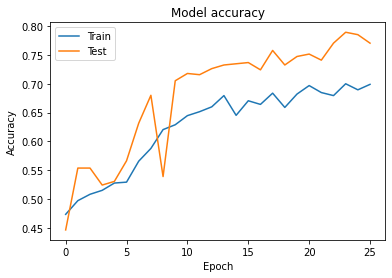

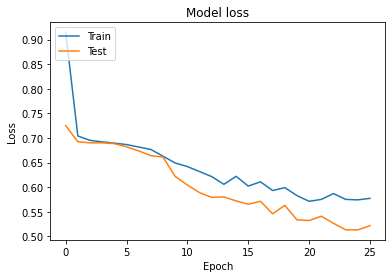

In [179]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 評価

evaluateで行う

In [180]:
model.evaluate(test_x[:,:,np.newaxis], test_y)

15/15 [==============================] - 0s 3ms/step - loss: 0.5218 - acc: 0.7705


[0.5218431353569031, 0.7705262899398804]